# Deep Learning Using Keras

## Trevor Nguyen and Bondith Sovann

## Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf

In [2]:
# Download Training Images
_URL = "https://ds-cnn.s3.amazonaws.com/chest_xray.zip"
path_to_zip = tf.keras.utils.get_file('chest_xray.zip', origin = _URL, extract = True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'chest_xray')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Train Dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle = True,
                                                            batch_size = BATCH_SIZE,
                                                            image_size = IMG_SIZE)

1228340377/1228340377 [==============================] - 36s 0us/step
Found 5216 files belonging to 2 classes.


In [3]:
# Validation Dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle = True,
                                                                 batch_size = BATCH_SIZE,
                                                                 image_size = IMG_SIZE)

Found 16 files belonging to 2 classes.


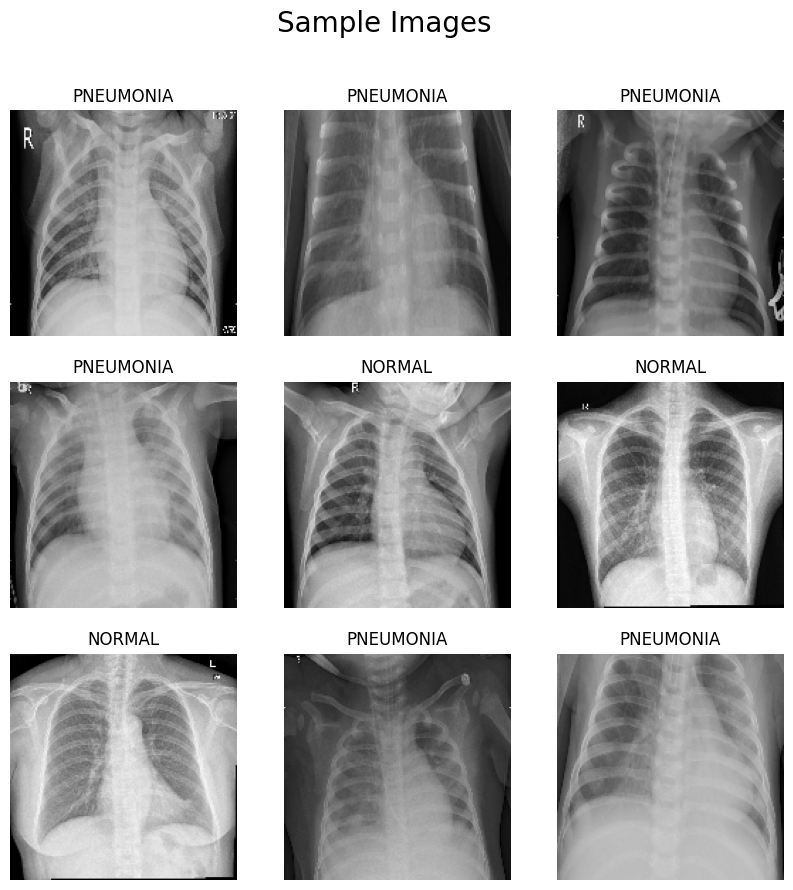

In [4]:
# Show the images
class_names = train_dataset.class_names

plt.figure(figsize = (10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.suptitle('Sample Images', fontsize = 20)
plt.show()

In [5]:
# Test dataset
test_dir = os.path.join(PATH, 'test')
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle = True,
                                                                 batch_size = BATCH_SIZE,
                                                                 image_size = IMG_SIZE)


Found 624 files belonging to 2 classes.


In [6]:
# Configure the dataset
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [7]:
# Use data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
])

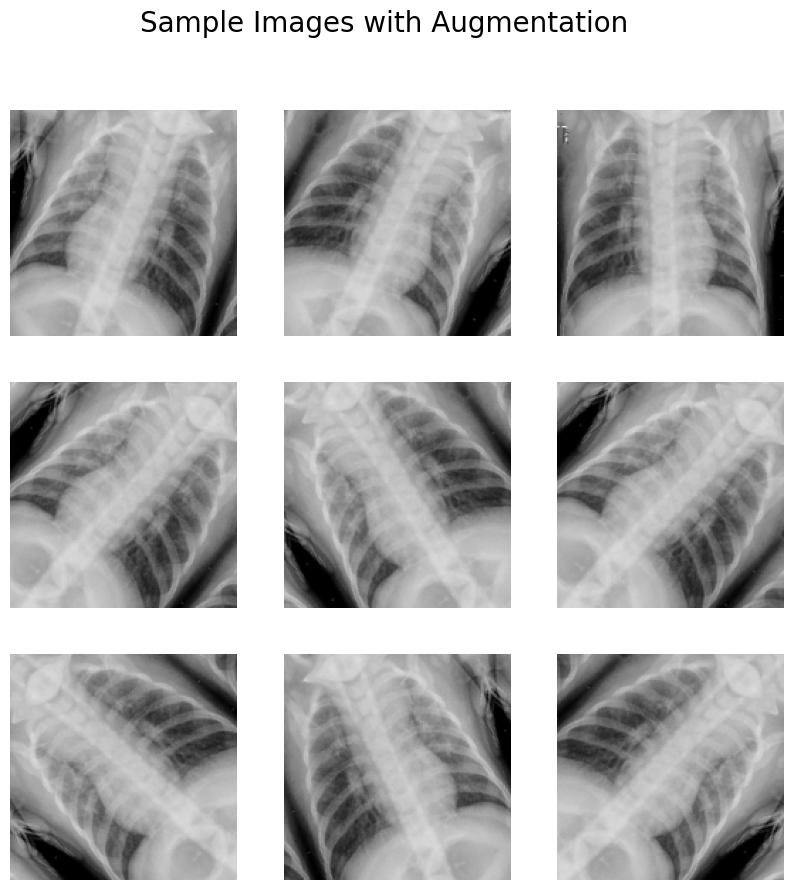

In [8]:
# Images with augmentation
for image, _ in train_dataset.take(1):
  plt.figure(figsize = (10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
  plt.suptitle('Sample Images with Augmentation', fontsize = 20)
  plt.show()

In [9]:
# Rescale pixel values to fit the expected pixel values of MobileNetV2 ([-1, 1])
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset = -1)

In [10]:
# Create base model (pre-trained model MobileNet V2)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
# converts each 160x160x3 image into a 5x5x1280 block of features.
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Model Construction & Results Analysis

In [12]:
# Freeze the convolutional base
base_model.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [14]:
# Add classication layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [16]:
# Build model by chaining together
inputs = tf.keras.Input(shape = (160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [18]:
len(model.trainable_variables)

2

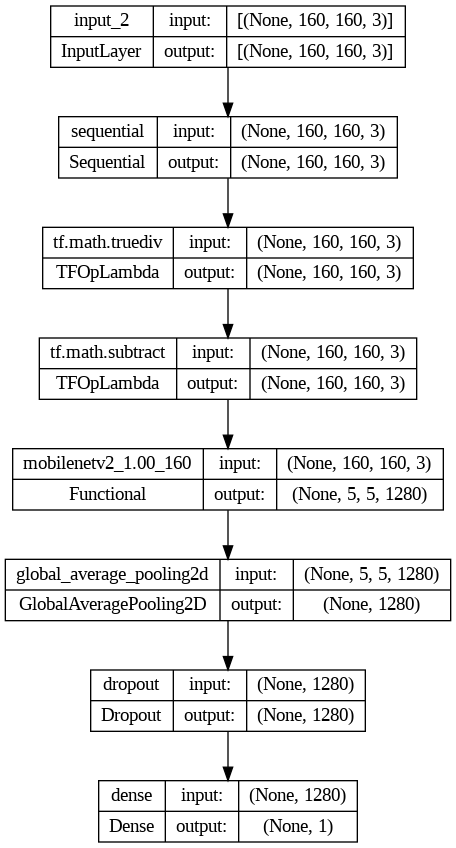

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
# Compile model
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = [tf.keras.metrics.BinaryAccuracy(threshold = 0, name = 'accuracy')])

In [21]:
# Train model
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

1/1 [==============================] - 2s 2s/step - loss: 0.6701 - accuracy: 0.5625


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.67
initial accuracy: 0.56


In [23]:
history = model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = validation_dataset)

Epoch 1/10
163/163 [==============================] - 167s 986ms/step - loss: 0.5863 - accuracy: 0.7063 - val_loss: 0.6130 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 156s 946ms/step - loss: 0.4286 - accuracy: 0.8048 - val_loss: 0.5006 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 160s 967ms/step - loss: 0.3534 - accuracy: 0.8455 - val_loss: 0.4608 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 154s 936ms/step - loss: 0.3143 - accuracy: 0.8604 - val_loss: 0.4273 - val_accuracy: 0.7500
Epoch 5/10
163/163 [==============================] - 164s 989ms/step - loss: 0.2811 - accuracy: 0.8836 - val_loss: 0.3895 - val_accuracy: 0.8125
Epoch 6/10
163/163 [==============================] - 153s 930ms/step - loss: 0.2594 - accuracy: 0.8938 - val_loss: 0.3972 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 152s 924ms/step - loss: 0.2439 - accuracy: 0.9038 - val_loss: 0.3822 -

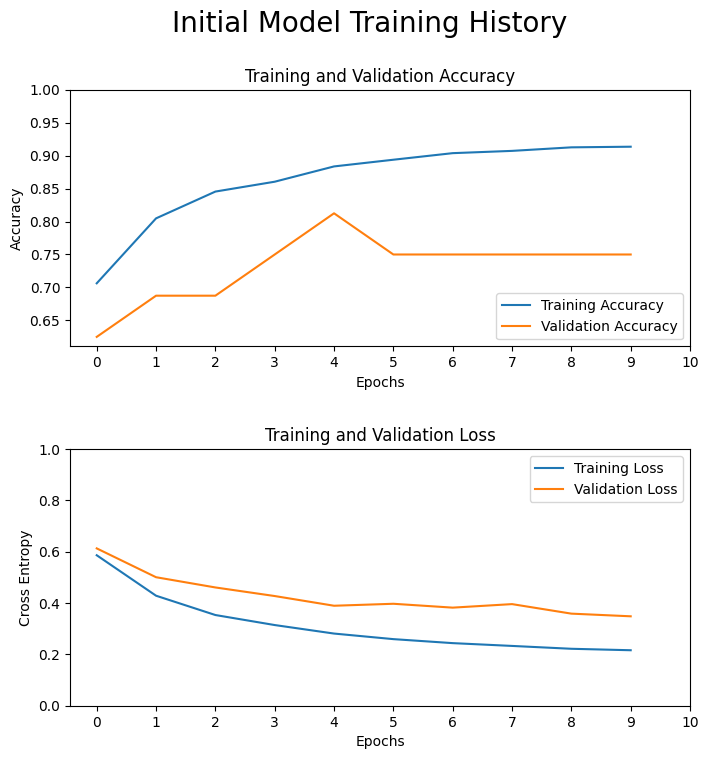

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 11, 1))
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0, 11, 1))
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplots_adjust(hspace = 0.4)
plt.suptitle("Initial Model Training History", fontsize = 20)
plt.show()

In [25]:
# Fine Tune
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model:", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 154


In [26]:
# Compile model again
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold = 0, name = 'accuracy')])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [28]:
len(model.trainable_variables)

56

In [29]:
# Train model again
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_dataset)

Epoch 10/20
163/163 [==============================] - 252s 2s/step - loss: 0.1721 - accuracy: 0.9335 - val_loss: 0.1274 - val_accuracy: 1.0000
Epoch 11/20
163/163 [==============================] - 237s 1s/step - loss: 0.1273 - accuracy: 0.9477 - val_loss: 0.1036 - val_accuracy: 1.0000
Epoch 12/20
163/163 [==============================] - 239s 1s/step - loss: 0.1100 - accuracy: 0.9607 - val_loss: 0.0888 - val_accuracy: 0.9375
Epoch 13/20
163/163 [==============================] - 244s 1s/step - loss: 0.1036 - accuracy: 0.9622 - val_loss: 0.1020 - val_accuracy: 1.0000
Epoch 14/20
163/163 [==============================] - 234s 1s/step - loss: 0.0943 - accuracy: 0.9632 - val_loss: 0.1783 - val_accuracy: 0.8750
Epoch 15/20
163/163 [==============================] - 239s 1s/step - loss: 0.0878 - accuracy: 0.9663 - val_loss: 0.0590 - val_accuracy: 1.0000
Epoch 16/20
163/163 [==============================] - 239s 1s/step - loss: 0.0814 - accuracy: 0.9689 - val_loss: 0.2327 - val_accuracy:

In [30]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

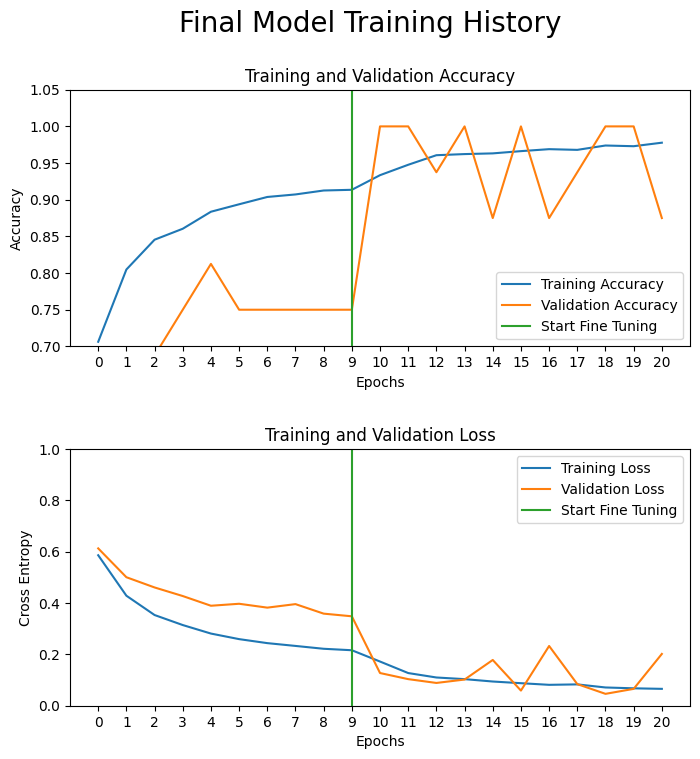

In [31]:
plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.xticks(np.arange(0, 21, 1))
plt.ylim([0.7, 1.05])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(np.arange(0, 21, 1))
plt.ylim([0, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.subplots_adjust(hspace = 0.4)
plt.suptitle('Final Model Training History', fontsize = 20)
plt.show()

In [32]:
# Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

20/20 [==============================] - 17s 751ms/step - loss: 0.6690 - accuracy: 0.7997
Test accuracy : 0.7996794581413269


Predictions:
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1]
Labels:
 [0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1]


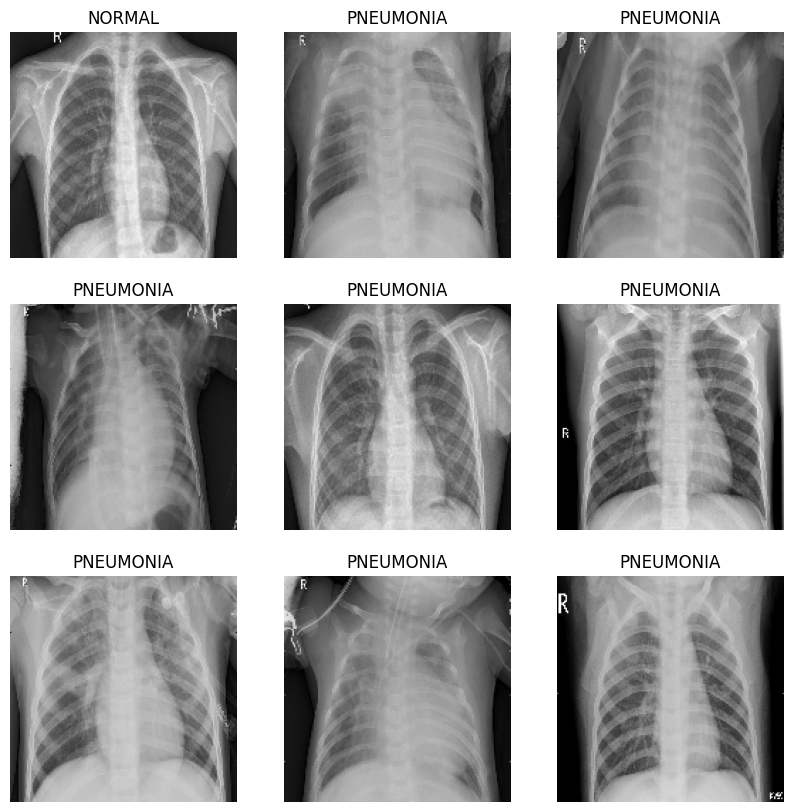

In [42]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

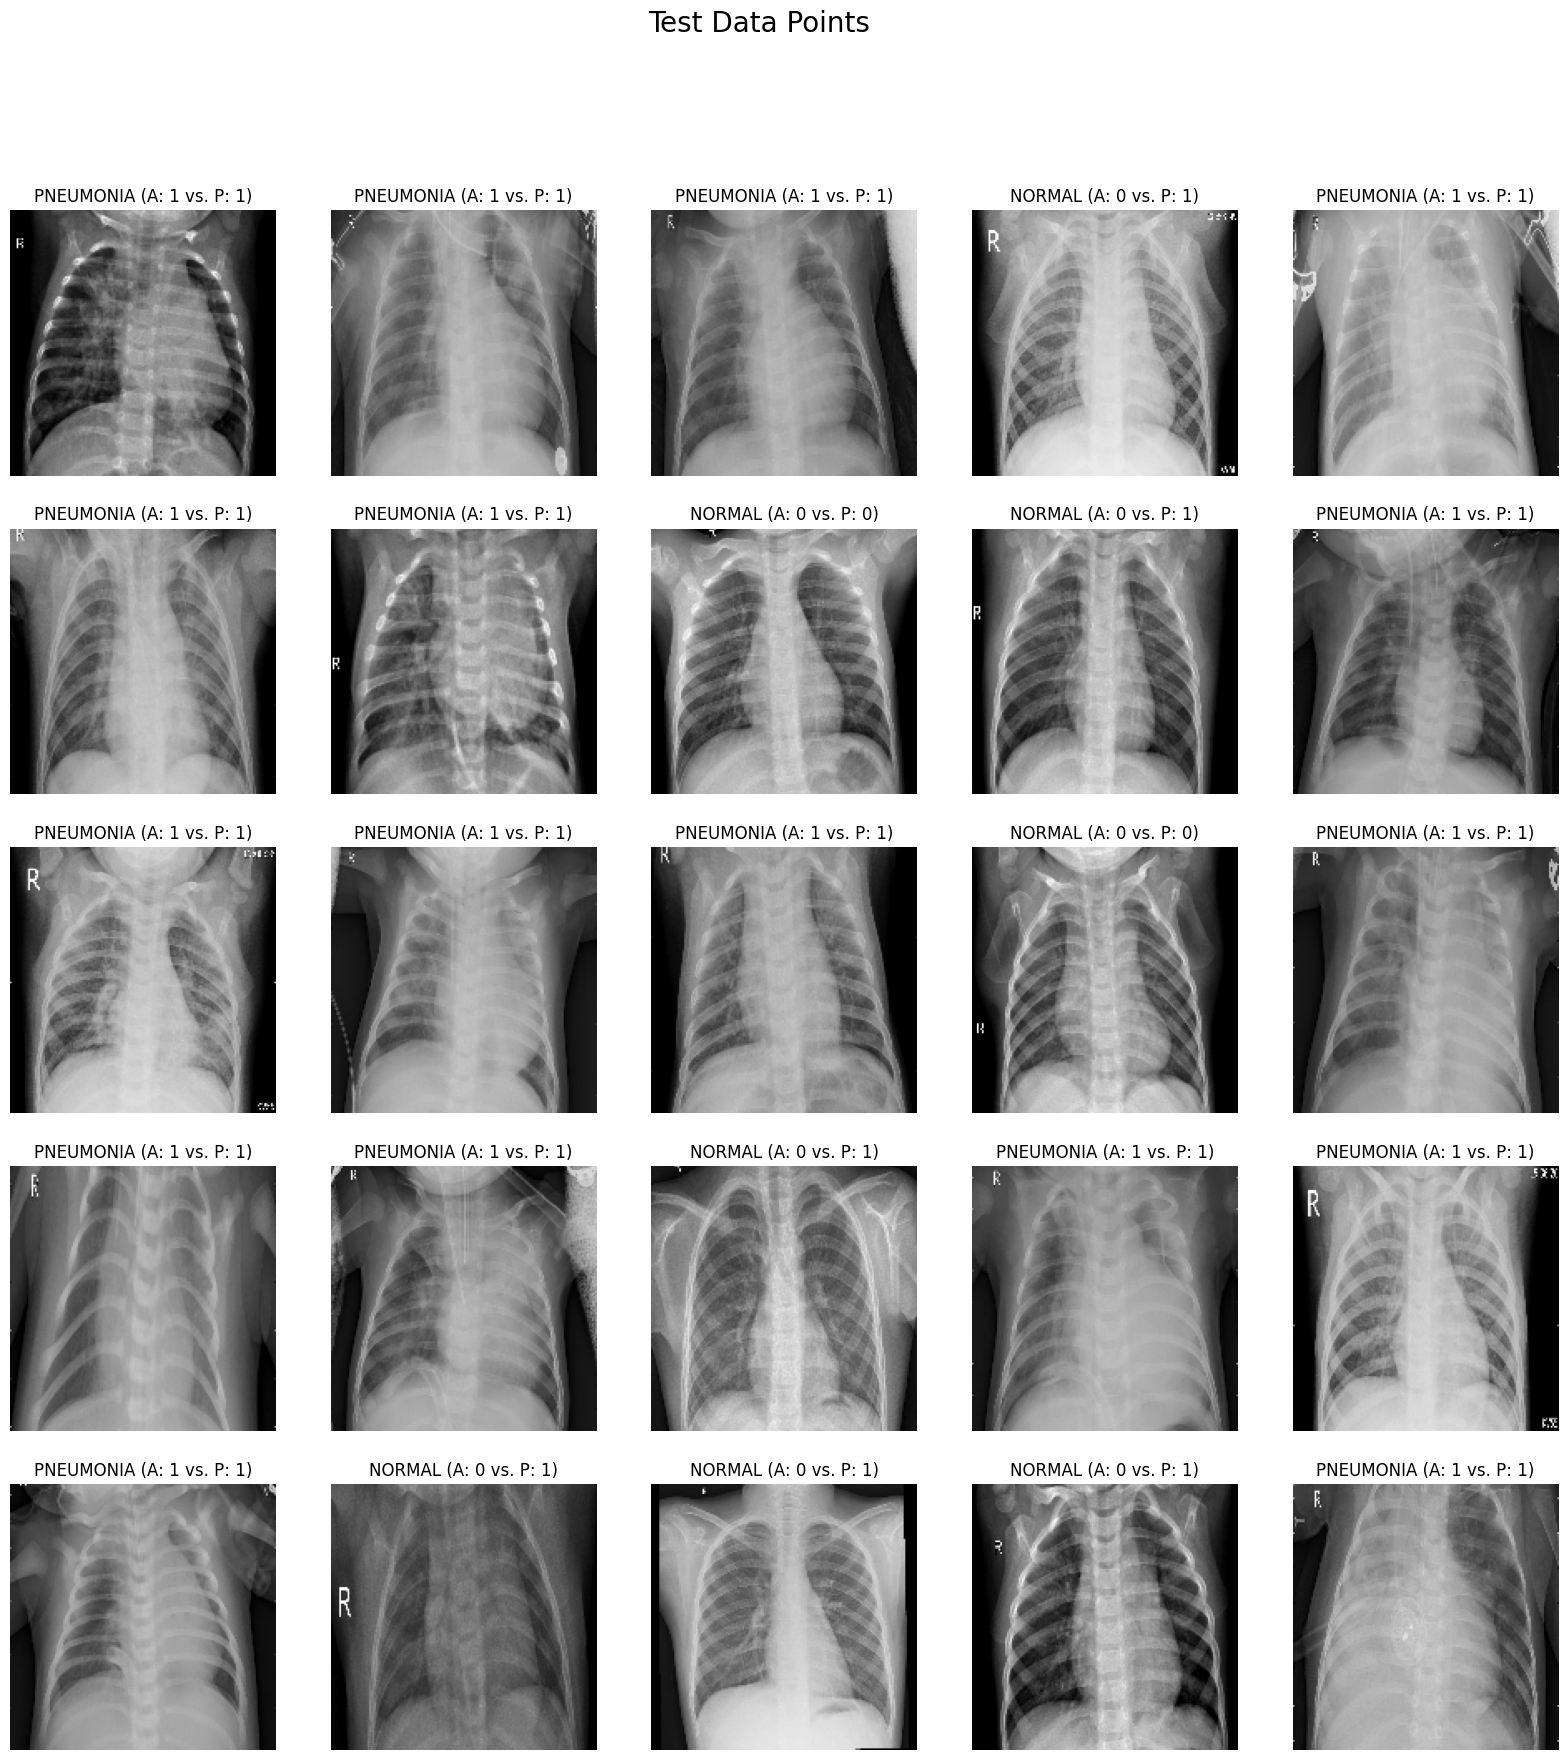

In [43]:
# Modify above code cell
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

# Set up the figure for plotting
plt.figure(figsize=(20, 20))

# Loop to plot the images
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))

    # Get the predicted and actual class labels
    predicted_class = class_names[predictions[i]]
    actual_class = class_names[label_batch[i]]

    # Set the title with class name and predicted vs. actual labels
    title_text = f"{class_names[label_batch[i]]} (A: {label_batch[i]} vs. P: {predictions[i]})"
    ax.set_title(title_text)
    plt.axis("off")

plt.suptitle('Test Data Points', fontsize = 20)
plt.show()

In [44]:
# Create a DataFrame with predictions and labels
data_points = pd.DataFrame({'Data Point': np.arange(1, 33, 1), 'Predicted': predictions.numpy(), 'Actual': label_batch})

data_points.head(25)

,Data Point,Predicted,Actual
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,0
4,5,1,1
5,6,1,1
6,7,1,1
7,8,0,0
8,9,1,0
9,10,1,1


In [36]:
history.history['accuracy']

[0.7062883377075195,
 0.8048312664031982,
 0.845475435256958,
 0.8604294657707214,
 0.8836272954940796,
 0.8937883377075195,
 0.9037576913833618,
 0.9072085618972778,
 0.9125766754150391,
 0.9135352969169617,
 0.9334739446640015,
 0.9476610422134399,
 0.9606978297233582,
 0.9622315764427185,
 0.9631901979446411,
 0.9662576913833618,
 0.9689416885375977,
 0.9679831266403198,
 0.9739263653755188,
 0.972967803478241,
 0.9777607321739197]

In [37]:
history.history['val_accuracy']

[0.625,
 0.6875,
 0.6875,
 0.75,
 0.8125,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 1.0,
 1.0,
 0.9375,
 1.0,
 0.875,
 1.0,
 0.875,
 0.9375,
 1.0,
 1.0,
 0.875]

In [38]:
history_fine.history['accuracy']

[0.9334739446640015,
 0.9476610422134399,
 0.9606978297233582,
 0.9622315764427185,
 0.9631901979446411,
 0.9662576913833618,
 0.9689416885375977,
 0.9679831266403198,
 0.9739263653755188,
 0.972967803478241,
 0.9777607321739197]

In [39]:
history_fine.history['val_accuracy']

[1.0, 1.0, 0.9375, 1.0, 0.875, 1.0, 0.875, 0.9375, 1.0, 1.0, 0.875]

In [40]:
table = pd.DataFrame({'Iteration': pd.Series(dtype = 'int64'),
                      'Number of Layers': pd.Series(dtype = 'int64'),
                      'Filter Size Layer 1': pd.Series(dtype = 'object'),
                      'Activation Function': pd.Series(dtype = 'object'),
                      'Training Accuracy': pd.Series(dtype = 'float'),
                      'Validation Accuracy': pd.Series(dtype = 'float')})
table['Iteration'] = np.arange(1, 21, 1)

table['Number of Layers'] = 8

table['Filter Size Layer 1'] = '(160, 160, 3)'

table['Activation Function'] = 'Rectified Linear Unit (ReLU)'

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
table['Training Accuracy'] = training_accuracy[:9] + training_accuracy[10:]
table['Validation Accuracy'] = validation_accuracy[:9] + validation_accuracy[10:]

In [41]:
table

,Iteration,Number of Layers,Filter Size Layer 1,Activation Function,Training Accuracy,Validation Accuracy
0,1,8,"(160, 160, 3)",Rectified Linear Unit (ReLU),0.706288,0.6250
1,2,8,"(160, 160, 3)",Rectified Linear Unit (ReLU),0.804831,0.6875
2,3,8,"(160, 160, 3)",Rectified Linear Unit (ReLU),0.845475,0.6875
3,4,8,"(160, 160, 3)",Rectified Linear Unit (ReLU),0.860429,0.7500
4,5,8,"(160, 160, 3)",Rectified Linear Unit (ReLU),0.883627,0.8125
5,6,8,"(160, 160, 3)",Rectified Linear Unit (ReLU),0.893788,0.7500
6,7,8,"(160, 160, 3)",Rectified Linear Unit (ReLU),0.903758,0.7500
7,8,8,"(160, 160, 3)",Rectified Linear Unit (ReLU),0.907209,0.7500
8,9,8,"(160, 160, 3)",Rectified Linear Unit (ReLU),0.912577,0.7500
9,10,8,"(160, 160, 3)",Rectified Linear Unit (ReLU),0.933474,1.0000
